In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("../data_folder/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


Посмотрим на то сколько классов - жанров музыки у нас есть. Так же посмотрим на средние и разбросы численных признаков и наличие пропущенных значений.

In [3]:
data.shape

(17996, 17)

In [4]:
set(data["Class"])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

У нас 17996 наблюдений и 16 признаков. В данных представлены 11 жанров.

In [5]:
data.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


In [6]:
data.isna().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

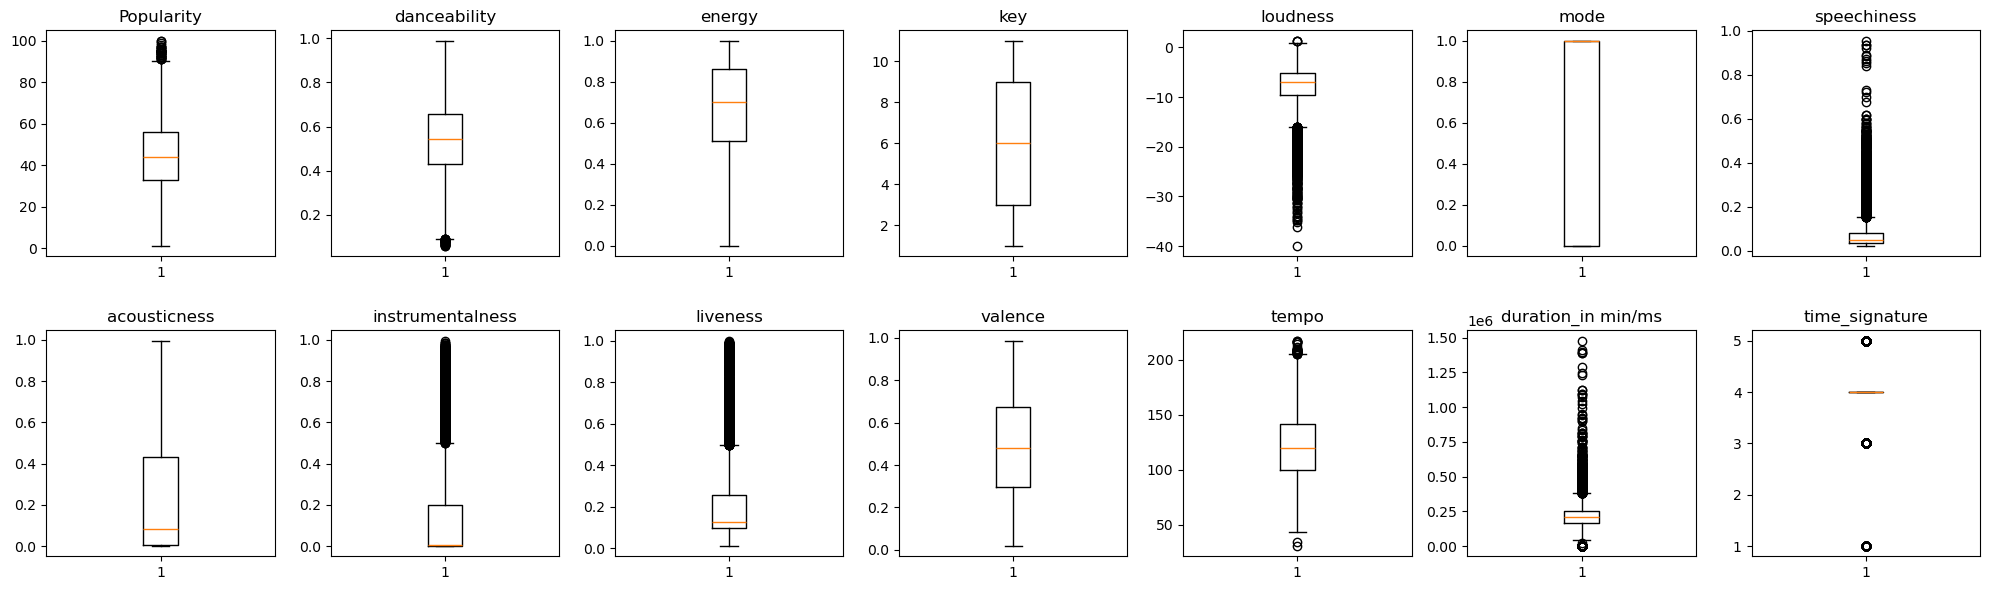

In [7]:
columns = data.columns.tolist()[2:-1]
num_rows = 2
num_cols = 7
fig, axes = plt.subplots(num_rows, num_cols,  figsize=(20, 6))

for i in range(len(columns)):
    ax = axes[i // num_cols, i % num_cols]
    ax.boxplot(data[columns[i]].dropna())
    ax.set_title(columns[i]) 


plt.tight_layout()
plt.show()

Три признака имеют NA и многие признаки имеют разные шкалы. Мы видим много выбросов, но я думаю, что эти признаки просто распределены ненормально.
У нас так же есть два текстовых признака - Artist Name и Track Name. Посмотрим могут ли они повторяться.

In [8]:
data.shape[0]

17996

In [9]:
len(set(data["Track Name"]))

15129

In [10]:
len(set(data["Artist Name"]))

9149

Проверим баланс классов.

In [11]:
data["Class"].value_counts()

10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: Class, dtype: int64

Выборка не сбалансирована по классам.

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Разделим данные на train и test, учитывая несбалансированность классов. Скейлить для дерева решений не обязательно, так как это не влияет на качество модели. Убрем отсутствующие значения, так как они в последующем мешают подбирать гиперпараметры.

In [12]:
data = data.dropna()
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 2:-1], 
                                                    data[['Class']], 
                                                    test_size=0.2, 
                                                    stratify=data[['Class']])

Обучим модель и предскажем жанры для тестовых данных. Используем accuracy для оценки качества модели. Она подходит для нашего случая, так как мы хотим максимально правильно определять все классы.

In [13]:
classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_pred

array([ 2, 10,  1, ...,  1,  1,  9], dtype=int64)

In [14]:
print("accuracy", accuracy_score(y_test, y_pred))

accuracy 0.35124841303427845


Метрика accuracy довольно низкая. Попробуем подобрать гиперпараметры.

In [15]:
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': [3, 5, 7, 10, None],
    'splitter': ["best", "random"]
}

grid_search = GridSearchCV(classifier, param_grid, cv=5)

In [16]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7, 10, None],
                         'splitter': ['best', 'random']})

In [17]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}
Best Score: 0.4622222222222222


Используем модель с лучшими параметрами и посмотрим на ее accuracy.

In [18]:
y_pred = grid_search.best_estimator_.predict(X_test)
print("accuracy", accuracy_score(y_test, y_pred))

accuracy 0.4595852729581041


Метрика accuracy улучшилась, но она все-таки низкая, поэтому это все же не такая уж хорошая модель на мой взгляд.

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Steins Gate - небольшая (кажется самоорганизованная) лаборатория открывает путешествия во времени. Классные выразительные персонажи и интересная история.

2. Arkane - кажется анимированный фильм, сделанный по игре (я никогда не играла). Нравится тем, что есть много интересных женских персонажей на первом плане.

3. Love Death + Robots - анимированный сериал. Каждый эпизод - отдельная история. Есть много интересных эпизодов.